
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [ ]:
!pip install -q pybullet Box2D
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 44.4 MB/s eta 0:00:00
Fri Sep  5 12:30:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W

Import necessary packages.

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gym.wrappers import RecordVideo
import gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [ ]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        state_dims = tuple(int(num) for num in state_dims)
        buffer_size = int(buffer_size)



        # TODO: Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        self.states = np.zeros((buffer_size, *state_dims), dtype=np.float32)
        self.states_ = np.zeros((buffer_size, *state_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.rewards = np.zeros((buffer_size, 1), dtype=np.float32)
        self.done = np.zeros((buffer_size, 1), dtype=np.float32)
        pass

    def store_transition(self, state, action, reward, state_, done):
        # TODO : Store the transition in the replay buffer
        self.states[self.ptr] = state
        self.states_[self.ptr] = state_
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.done[self.ptr] = done
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.is_full = True

        pass


    def load_batch(self, batch_size):
        # TODO: Sample a random batch of transitions from the buffer
        max_mem = self.buffer_size if self.is_full else self.ptr
        batch_indices = np.random.choice(max_mem, batch_size, replace=False)
        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        done = self.done[batch_indices]

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [ ]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, name+'_sac')
        if not os.path.exists(self.ckpt_dir):
            os.makedirs(self.ckpt_dir)


        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(self.state_dims[0] + self.action_dims, self.fc1_dims)

        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)



    def forward(self, state, action):
        # TODO 5: Implement the forward pass
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, name+'_sac')
        if not os.path.exists(self.ckpt_dir):
            os.makedirs(self.ckpt_dir)




        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(self.state_dims[0], self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(self.fc2_dims, self.action_dims)
        self.sigma = nn.Linear(self.fc2_dims, self.action_dims)
        self.log_std_min = -20
        self.log_std_max = 2

        # TODO 4: Define optimizer and move model to the appropriate device
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)



    def forward(self, state):
        #TODO
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.sigma(x)
        log_std = T.clamp(log_std, self.log_std_min, self.log_std_max)
        sigma = T.exp(log_std)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)

        # TODO 8: Create a normal distribution and sample from it
        probabilities = Normal(mu, sigma)
        if reparameterize:
            z = probabilities.rsample()
        else:
            z = probabilities.sample()

        action = T.tanh(z) * self.max_action
        log_probs = probabilities.log_prob(z).sum(axis=-1, keepdim=True)
        log_probs -= T.log(1 - T.tanh(z).pow(2) + 1e-6).sum(axis=-1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, name+'_sac')
        if not os.path.exists(self.ckpt_dir):
            os.makedirs(self.ckpt_dir)



        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(self.state_dims[0], self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)


    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [ ]:
class Agent:
    def __init__(self, gamma, alpha, beta,
                 state_dims, action_dims, max_action,
                 fc1_dim, fc2_dim,
                 memory_size, batch_size,
                 tau, update_period,
                 reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):

        self.gamma = gamma
        self.alpha = alpha
        self.beta  = beta

        self.state_dims  = state_dims
        self.action_dims = action_dims
        self.max_action  = max_action

        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim

        self.memory_size    = memory_size
        self.batch_size     = batch_size
        self.tau            = tau
        self.update_period  = update_period
        self.reward_scale   = reward_scale
        self.warmup         = warmup if warmup is not None else 0
        self.reparam_noise_lim = reparam_noise_lim

        self.name     = name
        self.ckpt_dir = ckpt_dir

        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

        model_name = (
            f'{name}__'
            f'gamma_{gamma:.2f}__alpha_{alpha:.4f}__beta_{beta:.4f}__'
            f'fc1_{fc1_dim}__fc2_{fc2_dim}__bs_{batch_size}__'
            f'buffer_{memory_size}__update_period_{update_period}__tau_{tau:.3f}__'
        )
        self.model_name = model_name
        self.full_path  = os.path.join(self.ckpt_dir, self.model_name)

        os.makedirs(self.full_path, exist_ok=True)

        self.learn_iter = 0

        self.memory = ReplayBuffer(self.memory_size, self.state_dims, self.action_dims)

        self.critic_1 = Critic(beta, self.state_dims, self.action_dims,
                               self.fc1_dim, self.fc2_dim,
                               name='Critic_1', ckpt_dir=self.full_path).to(self.device)

        self.critic_2 = Critic(beta, self.state_dims, self.action_dims,
                               self.fc1_dim, self.fc2_dim,
                               name='Critic_2', ckpt_dir=self.full_path).to(self.device)

        self.value = Value(beta, self.state_dims,
                           self.fc1_dim, self.fc2_dim,
                           name='Value', ckpt_dir=self.full_path).to(self.device)

        self.target_value = Value(beta, self.state_dims,
                                  self.fc1_dim, self.fc2_dim,
                                  name='TargetValue', ckpt_dir=self.full_path).to(self.device)

        self.actor = Actor(alpha, self.state_dims, self.action_dims,
                           self.fc1_dim, self.fc2_dim,
                           self.max_action, self.reparam_noise_lim,
                           name='Actor', ckpt_dir=self.full_path).to(self.device)

        self.update_parameters(tau=1.0)


    def choose_action(self, state, deterministic=False, reparameterize=False):
        """
        state: np.ndarray of shape (state_dims,)
        returns: np.ndarray of shape (action_dims,)
        """
        self.actor.eval()
        with T.no_grad():
            s = T.tensor(state, dtype=T.float32, device=self.device).unsqueeze(0)

            if deterministic:
                mu, _ = self.actor(s)
                action = T.tanh(mu) * self.max_action
            else:
                action, _ = self.actor.sample_normal(s, reparameterize=reparameterize)

        self.actor.train()
        return action.squeeze(0).detach().cpu().numpy()


    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        s, a, r, s_, d = self.memory.load_batch(self.batch_size)

        s  = T.tensor(s,  dtype=T.float32, device=self.device)
        a  = T.tensor(a,  dtype=T.float32, device=self.device)
        r  = T.tensor(r,  dtype=T.float32, device=self.device).view(-1, 1)
        s_ = T.tensor(s_, dtype=T.float32, device=self.device)
        d  = T.tensor(d,  dtype=T.float32, device=self.device).view(-1, 1)

        return s, a, r, s_, d


    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        for target_param, param in zip(self.target_value.parameters(),
                                       self.value.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def save_model(self):
        os.makedirs(self.full_path, exist_ok=True)
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        if self.memory.ptr < self.batch_size:
            return
        if self.learn_iter < self.warmup:
            self.learn_iter += 1
            return
        if self.learn_iter % self.update_period != 0:
            self.learn_iter += 1
            return

        states, actions, rewards, states_, dones = self.load_batch()

        with T.no_grad():
            new_actions_v, log_probs_v = self.actor.sample_normal(states, reparameterize=False)
            q1_v = self.critic_1(states, new_actions_v)
            q2_v = self.critic_2(states, new_actions_v)
            q_v  = T.min(q1_v, q2_v)

        v_pred = self.value(states)
        v_target = q_v - self.alpha * log_probs_v.unsqueeze(-1)
        value_loss = F.mse_loss(v_pred, v_target)

        self.value.optimizer.zero_grad(set_to_none=True)
        value_loss.backward()
        self.value.optimizer.step()

        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        q1_pi = self.critic_1(states, new_actions)
        q2_pi = self.critic_2(states, new_actions)
        q_pi  = T.min(q1_pi, q2_pi)

        actor_loss = (self.alpha * log_probs.unsqueeze(-1) - q_pi).mean()

        self.actor.optimizer.zero_grad(set_to_none=True)
        actor_loss.backward()
        self.actor.optimizer.step()

        with T.no_grad():
            v_next = self.target_value(states_)
            q_hat  = self.reward_scale * rewards + self.gamma * (1.0 - dones) * v_next

        q1 = self.critic_1(states, actions)
        q2 = self.critic_2(states, actions)

        critic1_loss = F.mse_loss(q1, q_hat)
        critic2_loss = F.mse_loss(q2, q_hat)

        self.critic_1.optimizer.zero_grad(set_to_none=True)
        critic1_loss.backward()
        self.critic_1.optimizer.step()

        self.critic_2.optimizer.zero_grad(set_to_none=True)
        critic2_loss.backward()
        self.critic_2.optimizer.step()

        self.update_parameters(self.tau)

        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [ ]:
# Configuration parameters


env_name = 'HalfCheetahBulletEnv-v0'
dir = 'tmp'
n_games = 300


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed
memory_size = 1000000
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.0
warmup = 10000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/300 [00:00<?, ?it/s]

| Game:      0 | Score:   -1018.39 | Best score:       -inf | Avg score   -1018.39 | Learning iter:        745 |
... saving checkpoint ...
| Game:      1 | Score:   -1248.44 | Best score:   -1018.39 | Avg score   -1133.42 | Learning iter:       1745 |
| Game:      2 | Score:   -1425.62 | Best score:   -1018.39 | Avg score   -1230.82 | Learning iter:       2745 |
| Game:      3 | Score:   -1440.28 | Best score:   -1018.39 | Avg score   -1283.18 | Learning iter:       3745 |
| Game:      4 | Score:   -1114.68 | Best score:   -1018.39 | Avg score   -1249.48 | Learning iter:       4745 |
| Game:      5 | Score:   -1135.41 | Best score:   -1018.39 | Avg score   -1230.47 | Learning iter:       5745 |
| Game:      6 | Score:   -1290.37 | Best score:   -1018.39 | Avg score   -1239.03 | Learning iter:       6745 |
| Game:      7 | Score:   -1307.78 | Best score:   -1018.39 | Avg score   -1247.62 | Learning iter:       7745 |
| Game:      8 | Score:   -1223.47 | Best score:   -1018.39 | Avg scor

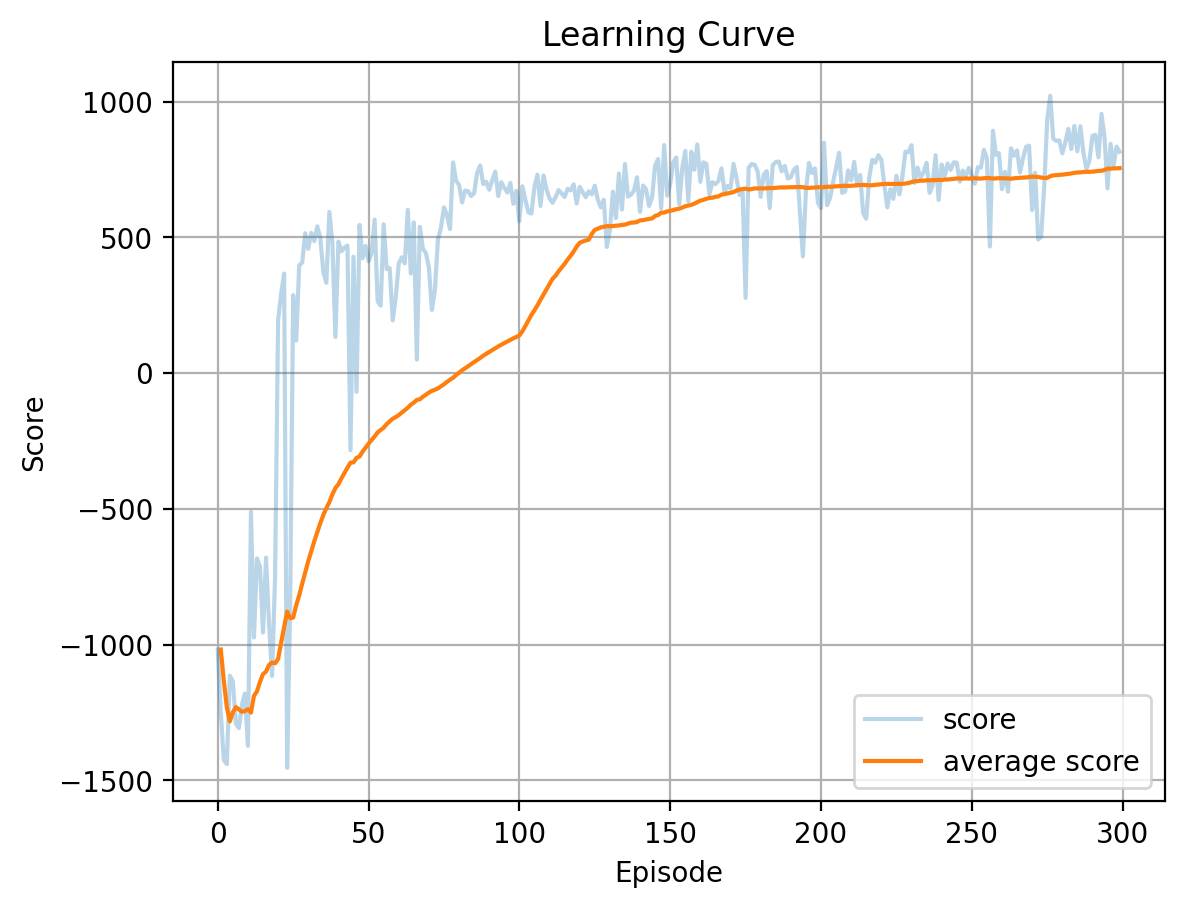

In [ ]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)



agent = Agent(gamma, alpha, beta, env.observation_space.shape, env.action_space.shape[0],
              env.action_space.high[0], fc1_dim, fc2_dim, 1e6, 256, tau, update_period,
              reward_scale, warmup, reparam_noise_lim, name='SAC', ckpt_dir=dir_path)


# TODO: Initialize performance tracking variables
best_score = -np.inf
scores = []
avg_score = 0
total_steps = 0



for game in trange(n_games):
    # TODO: Reset environment and initialize variables at the start of each episode
    done = False
    score = 0
    episode_steps = 0
    result = env.reset()
    if isinstance(result, tuple):
        observation, info = result
    else:
        observation = result


    # TODO: Interact with the environment until the episode is done
    while not done:
        action = agent.choose_action(observation, deterministic=False, reparameterize=False)

        result = env.step(action)
        if len(result) == 4:
            observation_, reward, done, info = result
        else:
            observation_, reward, done, truncated, info = result
            done = done or truncated

        agent.store_transition(observation, action, reward, observation_, float(done))
        agent.learn()

        if total_steps >= warmup:
          agent.update_parameters()

        total_steps += 1
        episode_steps += 1
        observation = observation_
        score += reward


    # TODO: Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')


    # TODO: Save the model if the current avg score is better than the best so far
    if avg_score > best_score:
        best_score = avg_score
        agent.save_model()


env.close()

plot_learning_curve(scores, agent.full_path)

In [ ]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)